# Livro: Python for Algorithmic Trading

# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np


#-----------------------------------------------------------
#Lê os dados do arquivo CSV.
#-----------------------------------------------------------
data = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2021.csv') 
data.head()
#print(df)
#df.info()

,time,open,high,low,close,Volume,Volume MA
0,2020-11-25T10:00:00-03:00,19.8550,19.9975,19.8000,19.8350,1427600,616260
1,2020-11-25T10:30:00-03:00,19.8400,19.9375,19.8125,19.8450,430000,608480
2,2020-11-25T11:00:00-03:00,19.8300,19.9275,19.8225,19.9075,130000,578580
3,2020-11-25T11:30:00-03:00,19.9150,19.9550,19.7375,19.8325,830800,588820
4,2020-11-25T12:00:00-03:00,19.8325,19.9475,19.7775,19.8425,420800,572060


In [2]:
#-----------------------------------------------------------
#Escolhe a coluna de série temporal única de interesse.
#-----------------------------------------------------------
symbol = "close"

data = pd.DataFrame(data[symbol])
data.head()


,close
0,19.8350
1,19.8450
2,19.9075
3,19.8325
4,19.8425


In [3]:
#-----------------------------------------------------------
#Renomeia a única coluna para price
#-----------------------------------------------------------

data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
0,19.8350
1,19.8450
2,19.9075
3,19.8325
4,19.8425


In [4]:
#-----------------------------------------------------------
# Calcula o log de retorno e define a direção como uma coluna binária.
#-----------------------------------------------------------

#Log Retorno
data['return'] = np.log(data['price']/data['price'].shift(1))

#Coluna binária
data['direction'] = np.where(data['return'] > 0, 1, 0)
#data.head()

display(data)

,price,return,direction
0,19.8350,NaN,0
1,19.8450,0.000504,1
2,19.9075,0.003144,1
3,19.8325,-0.003775,0
4,19.8425,0.000504,1
...,...,...,...
5647,22.6600,0.033658,1
5648,22.8300,0.007474,1
5649,23.0200,0.008288,1
5650,23.1100,0.003902,1


In [5]:
#Para a previsão do mercado de ações, é crucial encontrar dependências de tempo bem definidas
lags = 5

cols = []
#-----------------------------------------------------------
# Cria os Lagged Data
#-----------------------------------------------------------
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
#-----------------------------------------------------------
# Cria novas colunas DataFrame com os retornos de log deslocados pelo respectivo número de atrasos
#-----------------------------------------------------------
     data[col] = data['return'].shift(lag)
     cols.append(col)
#-----------------------------------------------------------
# Exclui as linhas que contêm valores NaN.
#-----------------------------------------------------------
data.dropna(inplace=True)

In [6]:
#-----------------------------------------------------------
# Imprime as cinco linhas finais indicando os “padrões” emergentes nas quatro colunas de recursos
#-----------------------------------------------------------

#data.round(4).tail() 
display(data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
6,19.7875,0.001391,1,-0.004166,0.000504,-0.003775,0.003144,0.000504
7,19.8525,0.003280,1,0.001391,-0.004166,0.000504,-0.003775,0.003144
8,19.8875,0.001761,1,0.003280,0.001391,-0.004166,0.000504,-0.003775
9,19.9850,0.004891,1,0.001761,0.003280,0.001391,-0.004166,0.000504
10,20.2550,0.013420,1,0.004891,0.001761,0.003280,0.001391,-0.004166
...,...,...,...,...,...,...,...,...
5647,22.6600,0.033658,1,-0.002279,-0.000910,0.003646,0.005954,0.010621
5648,22.8300,0.007474,1,0.033658,-0.002279,-0.000910,0.003646,0.005954
5649,23.0200,0.008288,1,0.007474,0.033658,-0.002279,-0.000910,0.003646
5650,23.1100,0.003902,1,0.008288,0.007474,0.033658,-0.002279,-0.000910


In [7]:
data[cols].values

array([[-0.00416641,  0.0005041 , -0.00377454,  0.00314446,  0.00050403],
       [ 0.00139073, -0.00416641,  0.0005041 , -0.00377454,  0.00314446],
       [ 0.00327952,  0.00139073, -0.00416641,  0.0005041 , -0.00377454],
       ...,
       [ 0.0074742 ,  0.0336581 , -0.00227946, -0.00091033,  0.00364631],
       [ 0.00828794,  0.0074742 ,  0.0336581 , -0.00227946, -0.00091033],
       [ 0.00390202,  0.00828794,  0.0074742 ,  0.0336581 , -0.00227946]])

# Separação

In [8]:
#-----------------------------------------------------------
# Importa o pacote TensorFlow.
#-----------------------------------------------------------
import tensorflow as tf
#-----------------------------------------------------------
# Importa o objeto de modelo necessário do Keras
#-----------------------------------------------------------
from keras.models import Sequential
#-----------------------------------------------------------
# Importa o objeto de camada relevante do Keras
#-----------------------------------------------------------
from keras.layers import Dense, Flatten
#-----------------------------------------------------------
# Importa a LSTM
#-----------------------------------------------------------
from tensorflow.keras.layers import LSTM, Input
#-----------------------------------------------------------
# Importa Layer weight regularizers
# https://keras.io/api/layers/regularizers/
#-----------------------------------------------------------
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam, RMSprop

#-----------------------------------------------------------
# Otimizador https://keras.io/api/optimizers/
#-----------------------------------------------------------
optimizer = Adam(learning_rate=0.0001)
#optimizer = Adam(learning_rate=.01)

In [9]:
## Definir o que é isso e para que server?
import random

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [10]:
set_seeds()

#-----------------------------------------------------------
# Um modelo Sequencial é instanciado.
#-----------------------------------------------------------
model=Sequential()

#-----------------------------------------------------------
# As camadas ocultas e a camada de saída são definidas.
#-----------------------------------------------------------
# Se cada amostra de entrada tiver 4 passos de tempo, onde cada passo de tempo 
# consiste em 1 valor de recurso, então a forma de entrada seria (4, 1).
# https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers
# O argumento input_shape recebe uma tupla de dois valores que definem o número de etapas de tempo e recursos.

model.add(LSTM(37 ,input_shape=(1,lags),return_sequences = True))
#model.add(Flatten()) #https://stackoverflow.com/questions/67952149/binary-classification-model-predicting-non-binary-what-problem-is-with-data-siz
model.add(Dense(1, activation='sigmoid'))

'''
model.add(LSTM(25, input_shape=(1, lags),return_sequences=True))
model.add(LSTM(20,return_sequences=True))
#model.add(LSTM(20,return_sequences=True))
#model.add(LSTM(15,return_sequences=True))
#model.add(LSTM(15,return_sequences=True))
model.add(Dense(1, activation='sigmoid'))
'''
#-----------------------------------------------------------
# Compila o objeto de modelo Sequencial para classificação.
#-----------------------------------------------------------
# https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function
# https://keras.io/api/losses/
model.compile(optimizer=optimizer,
 loss='binary_crossentropy',
# https://keras.io/api/metrics/
metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 37)             6364      
_________________________________________________________________
dense (Dense)                (None, 1, 1)              38        
Total params: 6,402
Trainable params: 6,402
Non-trainable params: 0
_________________________________________________________________


In [11]:
#-----------------------------------------------------------
# Define a data limite entre os dados de treinamento e teste.
#-----------------------------------------------------------
cutoff = 3952

"""                      TREINAMENTO                      """
#-----------------------------------------------------------
# Define os conjuntos de dados de treinamento.
#-----------------------------------------------------------
training_data = data[data.index < cutoff].copy()
#print(training_data[cols])

#-----------------------------------------------------------
# Normalizes the features data by Gaussian normalization. (z-score)
#-----------------------------------------------------------
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
#print(training_data_[cols])



"""-------------------Dados de Entrada--------------------"""

#-----------------------------------------------------------
# Pega os dados de 'Lag' de treinamentos e coloca na variavel X_train
#-----------------------------------------------------------
X_train = training_data[cols].values
X_train_ = training_data_[cols].values


#-----------------------------------------------------------
# Redefine os dados de treinamento para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
X_train = X_train.reshape(len(X_train),1,lags)
X_train_ = X_train_.reshape(len(X_train_),1,lags)


"""-------------------Dados de Saida----------------------"""

#-----------------------------------------------------------
# Pega os dados de direção(0 e 1) de treinamento e coloca na variavel Y_train
#-----------------------------------------------------------
Y_train = training_data['direction'].values
Y_train_ = training_data_['direction'].values

#-----------------------------------------------------------
# Quantos 0 e quantos 1 possuem no meu dado de Teste? 
#-----------------------------------------------------------
count1 = 0
count0 = 0
for i in Y_train:
    if i == 1:
        count1 += 1
    elif i == 0:
        count0 += 1
print("TREINAMENTO ")
print("Quantos 1 tem na saida? ",count1)
print("Quantos 0 tem na saida? ",count0)
print("Total: ",len(Y_train))

#-----------------------------------------------------------
# Redefine os dados de direção treinamento para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
Y_train = Y_train.reshape(len(Y_train),1,1)
Y_train_ = Y_train_.reshape(len(Y_train_),1,1)



"""                           TESTE                     """
#-----------------------------------------------------------
# Define os conjuntos de dados de teste.
#-----------------------------------------------------------
test_data = data[data.index >= cutoff].copy()
#print(test_data[cols])

#-----------------------------------------------------------
# Normalizes the features data by Gaussian normalization.
#-----------------------------------------------------------
test_data_ = (test_data - mu) / std
#print(test_data_[cols])

"""-------------------Dados de Entrada--------------------"""

#-----------------------------------------------------------
# Pega os dados de 'Lag' de teste e coloca na variavel X_test
#-----------------------------------------------------------
X_test = test_data[cols].values
X_test_ = test_data_[cols].values

#-----------------------------------------------------------
# Redefine os dados de 'Lag' teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
X_test = X_test.reshape(len(X_test),1,lags)
X_test_ = X_test_.reshape(len(X_test_),1,lags)


"""-------------------Dados de Saida----------------------"""

#-----------------------------------------------------------
# Pega os dados de direção(0 e 1) de teste e coloca na variavel Y_teste
#-----------------------------------------------------------
Y_test = test_data['direction'].values
Y_test_ = test_data_['direction'].values
#print(Y_test)

#-----------------------------------------------------------
# Quantos 0 e quantos 1 possuem no meu dado de Teste? 
#-----------------------------------------------------------
count1 = 0
count0 = 0
for i in Y_test:
    if i == 1:
        count1 += 1
    elif i == 0:
        count0 += 1
        
print("TESTE ")
print("Quantos 1 tem na saida? ",count1)
print("Quantos 0 tem na saida? ",count0)
print("Total: ",len(Y_test))

#-----------------------------------------------------------
# Redefine os dados de direção teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
Y_test = Y_test.reshape(len(Y_test),1,1)
Y_test_ = Y_test_.reshape(len(Y_test_),1,1)



TREINAMENTO 
Quantos 1 tem na saida?  1942
Quantos 0 tem na saida?  2004
Total:  3946
TESTE 
Quantos 1 tem na saida?  790
Quantos 0 tem na saida?  910
Total:  1700


In [12]:
%%time
#-----------------------------------------------------------
# Ajusta o modelo ao conjunto de dados de treinamento.
#-----------------------------------------------------------
# model.fit(training_data[cols], # Lags
#    training_data['direction'], # 0 e 1
#    epochs=250, verbose=False, batch_size=100,
#    validation_split=0.5, shuffle=False)

model.fit(X_train, # Lags
    Y_train, # 0 e 1
    epochs=50, verbose=False,
    #validation_data = (X_test, Y_test),
    validation_split=0.4, #Gera conjunto de dados de validação aleatórios
          shuffle=False)

CPU times: user 18.4 s, sys: 1.52 s, total: 19.9 s
Wall time: 12.2 s


In [13]:
res = pd.DataFrame(model.history.history)
model.history.history
res.head()
#display(res)

,loss,accuracy,val_loss,val_accuracy
0,0.693151,0.497254,0.693151,0.499050
1,0.693149,0.506126,0.693155,0.488917
2,0.693148,0.502746,0.693160,0.481951
3,0.693147,0.501479,0.693164,0.486384
4,0.693145,0.501901,0.693168,0.483851


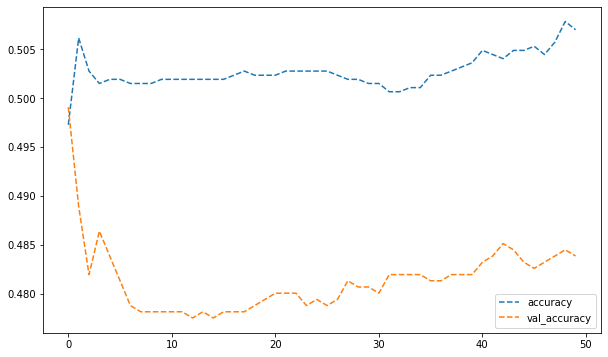

In [14]:
#-----------------------------------------------------------
# Precisão do classificador LSTM nos dados de treinamento e validação por etapa de treinamento
#-----------------------------------------------------------

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

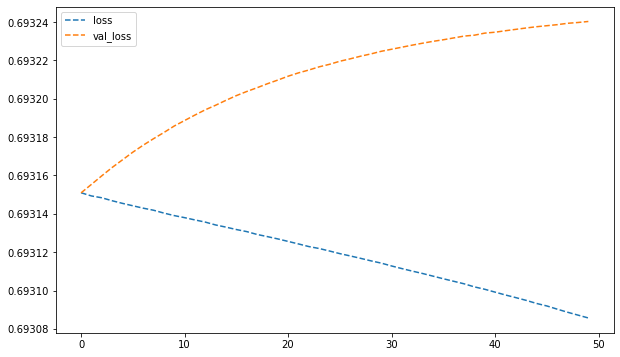

In [15]:
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');

In [16]:
'''DADOS DE TREINAMENTO'''

#-----------------------------------------------------------
# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)
# A avaliação é um processo durante o desenvolvimento do modelo para 
# verificar se o modelo é o mais adequado para um determinado problema 
# e dados correspondentes. O modelo Keras fornece uma função, avaliar, 
# que faz a avaliação do modelo. Tem três argumentos principais,
# - Dados de teste
# - Rótulo de dados de teste
# - verboso - verdadeiro ou falso
# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ 
#-----------------------------------------------------------
#model.evaluate(X_train_, Y_train)
model.evaluate(X_test, Y_test)

#-----------------------------------------------------------
# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)
# A previsão é a etapa final e nosso resultado esperado da geração do modelo. 
# Keras fornece um método de previsão para obter a previsão do modelo treinado
# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ 
#-----------------------------------------------------------
pred = model.predict(X_train_) 
#pred = model.predict(X_train) 
#print(pred)


#-----------------------------------------------------------
# Interpretação da saida do modelo
# https://datascience.stackexchange.com/questions/65995/tensorflow-sigmoid-activation-function-as-output-layer-value-interpretation
#-----------------------------------------------------------
pred = np.where(model.predict(X_train_) > 0.5, 1, 0)

#pred = np.where(model.predict(X_test) > 0.5, 1, 0)


#print(pred.shape)
#pred.flatten()
#print(pred)
pred = pred.reshape(len(pred),1)
#print(pred.shape)
#print(pred)
valores_preditos = [] # predicao
valores_reais = [] # direcao
# for predicao, direcao in zip(pred, Y_test):
for predicao, direcao in zip(pred, Y_train):
    valores_preditos.append(int(predicao))
    valores_reais.append(int(direcao))
    #print('Predição: {} / Direção: {}'.format(int(predicao), int(direcao)))


54/54 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.4806


In [17]:
#-----------------------------------------------------------
# Matriz de Confusão
# Fonte: https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509
#-----------------------------------------------------------

import numpy as np

# 1 para subida, 0 para descida
# print(valores_preditivos)
# print(valores_reais)

def get_confusion_matrix(reais, preditos, labels):
    """
    Uma função que retorna a matriz de confusão para uma classificação binária
    
    Args:
        reais (list): lista de valores reais
        preditos (list): lista de valores preditos pelo modelos
        labels (list): lista de labels a serem avaliados.
            É importante que ela esteja presente, pois usaremos ela para entender
            quem é a classe positiva e quem é a classe negativa
    
    Returns:
        Um numpy.array, no formato:
            numpy.array([
                [ tp, fp ],
                [ fn, tn ]
            ])
    """
    # não implementado
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = labels[0]
    negative_class = labels[1]

    # valores preditos corretamente
    tp = 0
    tn = 0
    
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])

get_confusion_matrix(reais=valores_reais, preditos=valores_preditos, labels=[1,0])


#Valores de Teste

                    # Valores preditos
#                      Subida , Descida 
# Valores reais
#                Subida  [355, 435],
#                Descida [412, 498]


# Previu Subida 355 vezes corretamente
# Previu Descida 498 vezes corretamente
# Previu Subida 435 vez incorretamente
# Previu Descida 412 vezes incorretamente 


#Valores de Treinamento

                    # Valores preditos
#                      Subida , Descida 
# Valores reais
#                Subida  [903, 1039],
#                Descida [881, 1123]

# Previu Subida 903 vezes corretamente
# Previu Descida 1123 vezes corretamente
# Previu Subida 1039 vez incorretamente
# Previu Descida 881 vezes incorretamente 

array([[1039,  903],
       [1030,  974]])

In [18]:
# Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

from sklearn.metrics import classification_report

print(classification_report(valores_reais, valores_preditos, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.52      0.49      0.50      2004
           1       0.50      0.54      0.52      1942

    accuracy                           0.51      3946
   macro avg       0.51      0.51      0.51      3946
weighted avg       0.51      0.51      0.51      3946



# Matriz de Confusão